In [1]:
from pathlib import Path
import numpy as np
from tqdm import trange
from dm_control.mujoco import Camera as DMCamera
from flygym import Fly, Camera
from flygym.examples.turning_controller import HybridTurningNMF
from flygym.util import load_config

legs = ["LF", "LM", "LH", "RF", "RM", "RH"]
segments = [
    "Coxa",
    "Femur",
    "Tibia",
    "Tarsus1",
    "Tarsus2",
    "Tarsus3",
    "Tarsus4",
    "Tarsus5",
]
leg_segments = [leg + segment for leg in legs for segment in segments]
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in [
        "Tibia",
        "Tarsus1",
        "Tarsus2",
        "Tarsus3",
        "Tarsus4",
        "Tarsus5",
    ]
]

fly = Fly(
    enable_vision=True,
    vision_refresh_rate=500,
    contact_sensor_placements=contact_sensor_placements,
    render_raw_vision=True,
    head_stabilization_kp=1000,
)

effector_sensors = {}
for name in leg_segments:
    if name.endswith("5"):
        sensor = dict(zip(legs, fly._end_effector_sensors))[name[:2]]
    else:
        sensor = fly.model.sensor.add(
            "framepos",
            name=f"{name}_pos",
            objtype="body",
            objname=name,
        )
    effector_sensors[name] = sensor

cam = Camera(
    fly=fly,
    camera_id="Animat/camera_front",
    fps=24,
    window_size=(800, 608),
    play_speed=0.2,
)

sim = HybridTurningNMF(
    fly=fly,
    cameras=[cam],
    timestep=1 / 10000,
)

vision_config = load_config()["vision"]
width = vision_config["raw_img_width_px"]
height = vision_config["raw_img_height_px"]

dm_cameras = [
    DMCamera(
        sim.physics,
        camera_id=f"{fly.name}/{side}Eye_cam",
        width=width,
        height=height,
    )
    for side in "LR"
]

sim.reset(seed=0)

effector_pos = []
vision_hist = []
raw_vision_hist = []
extrinsic_matrices = []


def get_extrinsic_matrix(dm_camera):
    A, B, C, D = dm_camera.matrices()
    return C @ D


for i in trange(10000):
    obs, _, _, _, info = sim.step(np.array([1.0, 1.0]))
    effector_pos.append(
        sim.physics.bind(list(effector_sensors.values()))
        .sensordata.copy()
        .reshape((-1, 3))
    )
    render_results = sim.render()[0]
    extrinsic_matrices.append(np.array([get_extrinsic_matrix(i) for i in dm_cameras]))

    if render_results is not None:
        vision_hist.append(obs["vision"].copy())
        raw_vision_hist.append(info["raw_vision"].copy())

100%|██████████| 10000/10000 [00:18<00:00, 528.99it/s]


In [2]:
effector_pos = np.array(effector_pos)
# (n_steps, n_legs * n_segments, |{x, y, z}|)
print(f"{effector_pos.shape=}")

effector_pos.shape=(10000, 48, 3)


In [3]:
extrinsic_matrices = np.array(extrinsic_matrices)
# (n_steps, |{camera_l_eye, camera_r_eye}|, 4, 4)
print(f"{extrinsic_matrices.shape=}")

# homogeneous world coordinates
Xw = np.tile(
    np.concatenate((effector_pos, np.ones((*effector_pos.shape[:-1], 1))), axis=-1)[
        :, None
    ],
    [1, 2, 1, 1],
)
# (n_steps, |{camera_l_eye, camera_r_eye}|, n_legs * n_segments, |{x, y, z, 1}|)
print(f"{Xw.shape=}")

# joint positions in camera coordinates
Xc = (Xw[:, :, :, None] * extrinsic_matrices[:, :, None]).sum(-1)
Xc = Xc.reshape((len(Xc), 2, 6, 8, -1))
Xc = Xc[..., :-1] / Xc[..., [-1]]

# (n_steps, |{camera_l_eye, camera_r_eye}|, n_legs, n_segments, |{x, y, z}|)
print(f"{Xc.shape=}")

extrinsic_matrices.shape=(10000, 2, 4, 4)
Xw.shape=(10000, 2, 48, 4)
Xc.shape=(10000, 2, 6, 8, 3)


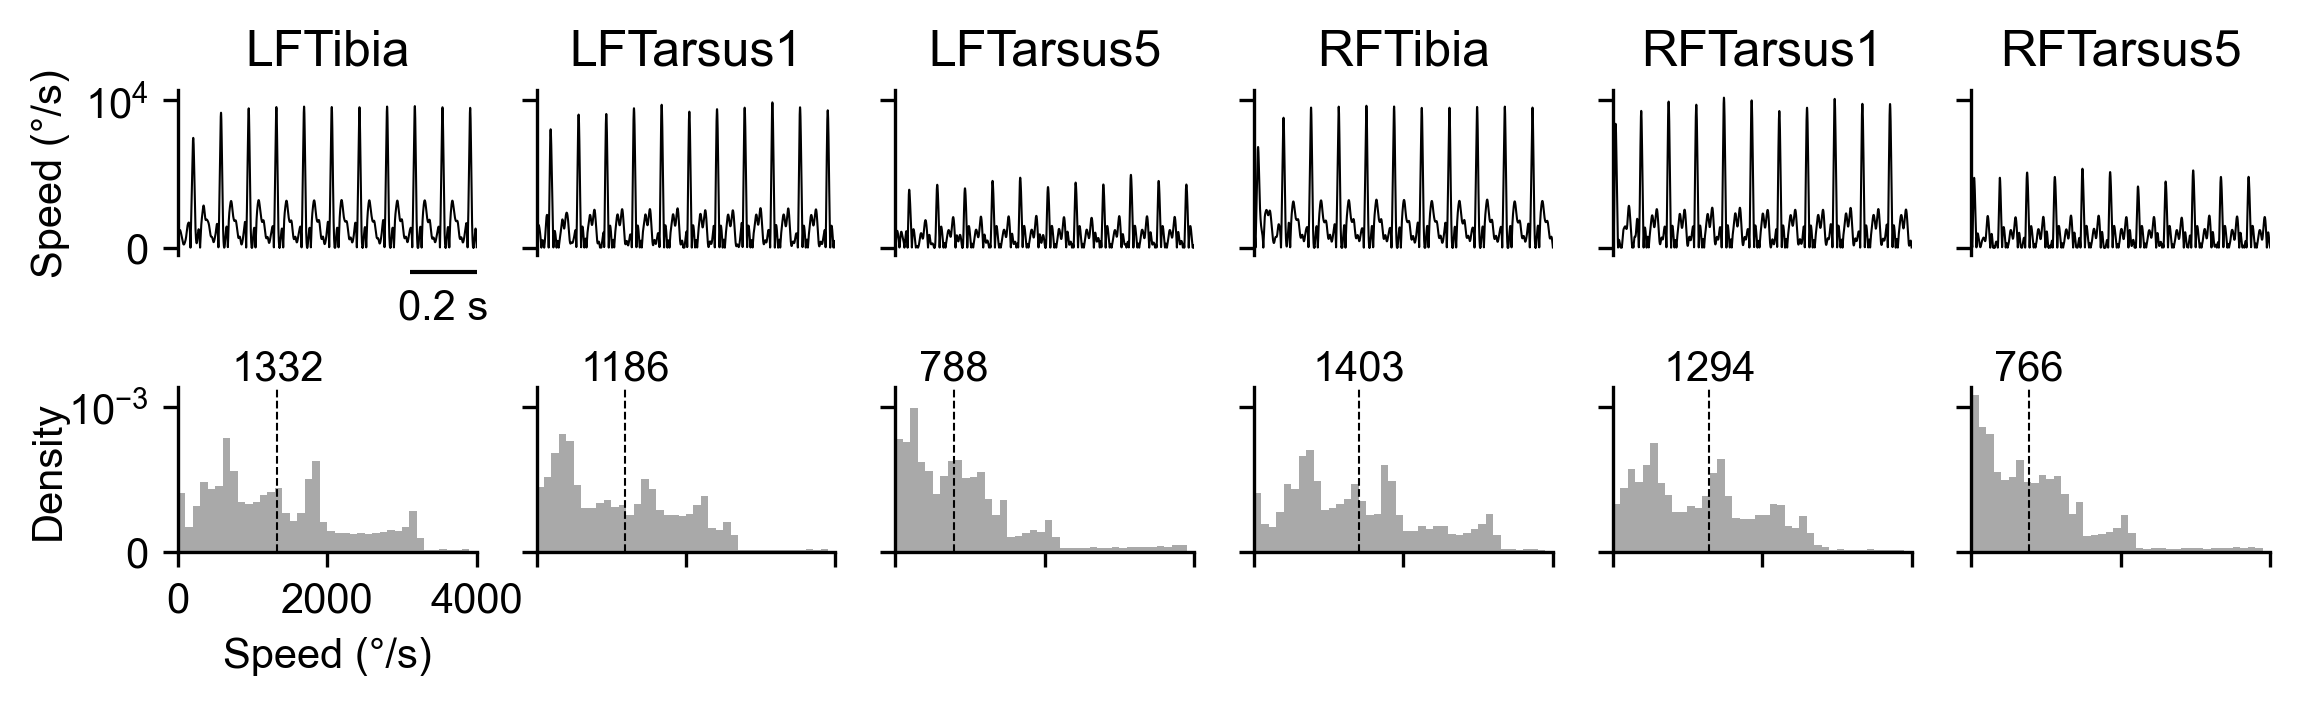

In [4]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Arial"

n_rows = 2
n_cols = 6

fig, axs = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * 1.5, n_rows * 1),
    sharex="row",
    sharey="row",
    dpi=300,
    gridspec_kw=dict(hspace=0.8),
)

for i_leg in range(3):
    for i_side in range(2):
        # get position of leg joint in camera coordinates
        X = Xc[:, i_side, i_side * 3, [2, 3, -1][i_leg]].T

        # convert to azimuth angle
        angle = np.rad2deg(np.arctan(X[0] / X[-1]))

        # speed = np.abs(np.gradient(angle[1000:])) / 1e-4
        speed = np.abs(gaussian_filter1d(angle[1000:], 20, order=1) / 1e-4)

        ax = axs[0, i_side * 3 + i_leg]
        t = np.arange(len(speed)) / 10000
        ax.plot(t, speed, c="k", lw=0.5)
        ax.set_title(f"{'LR'[i_side]}F{['Tibia', 'Tarsus1', 'Tarsus5'][i_leg]}")
        ax.set_xmargin(0)

        ax = axs[1, i_side * 3 + i_leg]
        ax.hist(speed, bins=np.arange(0, 4000, 100), color="darkgray", density=True)
        ax.axvline(np.median(speed), color="k", linestyle="--", lw=0.5)
        ax.text(
            np.median(speed),
            1,
            f"{np.median(speed):.0f}",
            ha="center",
            va="bottom",
            transform=ax.get_xaxis_transform(),
        )
        ax.set_xlim(t.min(), t.max())
        ax.set_facecolor("none")

for ax in axs[0].ravel():
    ax.xaxis.set_visible(False)

axs[0, 0].set_yticks([0, 10000], labels=[0, "10$^4$"])
axs[1, 0].set_yticks([0, 0.001], labels=[0, "10$^{-3}$"])

for ax in axs[1, 1:].ravel():
    ax.xaxis.set_tick_params(labelbottom=False)

ax = axs[0, 0]
tmax = ax.get_xlim()[1]
ax.plot(
    [tmax - 0.2, tmax],
    [-0.1] * 2,
    c="k",
    transform=ax.get_xaxis_transform(),
    lw=1,
    clip_on=False,
    solid_capstyle="butt",
)
ax.text(
    tmax - 0.1,
    -0.2,
    "0.2 s",
    ha="center",
    va="top",
    transform=ax.get_xaxis_transform(),
)

axs[0, 0].set_ylabel("Speed (°/s)", labelpad=3.6)
axs[1, 0].set_ylabel("Density", labelpad=0)

axs[1, 0].set_xlim(0, 4000)
axs[1, 0].set_xlabel("Speed (°/s)")

for ax in axs[0]:
    for spine in ("top", "right", "bottom"):
        ax.spines[spine].set_visible(False)

for ax in axs[1]:
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

fig.set_facecolor("white")

Path("./outputs").mkdir(exist_ok=True, parents=True)
plt.savefig("./outputs/leg_joints_angular_speed.pdf", bbox_inches="tight")